In [20]:
# Install necessary packages
%pip install roboflow --quiet
%pip install ultralytics --quiet
%matplotlib inline

# Imports
import os
import random
import yaml
import torch
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
from roboflow import Roboflow
from PIL import Image


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Roboflow API setup
rf = Roboflow(api_key="nkNirI4vKOWc6iQRQKh2")
project = rf.workspace("construction-helmet").project("construction-helmet-detection")
version = project.version(2)
dataset = version.download("yolov8")

# Base dataset path
DATASET_ROOT = r"C:\Users\sharm\Downloads\Helmet_Detection\notebook\construction-helmet-detection-2"


In [ ]:
splits = ["train", "valid", "test"]

for split in splits:
    img_folder = os.path.join(DATASET_ROOT, split, "images")
    lbl_folder = os.path.join(DATASET_ROOT, split, "labels")
    
    print(f"\n--- {split.upper()} ---")
    
    if os.path.exists(img_folder):
        print(f"Images ({len(os.listdir(img_folder))}): {os.listdir(img_folder)[:5]} ...")
    else:
        print(f"Images folder not found: {img_folder}")
    
    if os.path.exists(lbl_folder):
        print(f"Labels ({len(os.listdir(lbl_folder))}): {os.listdir(lbl_folder)[:5]} ...")
    else:
        print(f"Labels folder not found: {lbl_folder}")


In [ ]:
yaml_path = os.path.join(DATASET_ROOT, "data.yaml")

classes = ["with_helmet", "without_helmet"]

# Create or fix data.yaml
if os.path.exists(yaml_path):
    with open(yaml_path, 'r') as f:
        data_yaml = yaml.safe_load(f)
else:
    data_yaml = {}

data_yaml["names"] = classes
data_yaml["nc"] = len(classes)
data_yaml["train"] = os.path.join(DATASET_ROOT, "train", "images")
data_yaml["val"] = os.path.join(DATASET_ROOT, "valid", "images")
data_yaml["test"] = os.path.join(DATASET_ROOT, "test", "images")

with open(yaml_path, 'w') as f:
    yaml.safe_dump(data_yaml, f)

print("\n✅ Dataset and data.yaml are ready")
print("Classes:", data_yaml["names"])
print("Number of classes:", data_yaml["nc"])


In [ ]:
for split in ["train", "valid", "test"]:
    img_folder = os.path.join(DATASET_ROOT, split, "images")
    n = len(os.listdir(img_folder)) if os.path.exists(img_folder) else 0
    print(f"{split}: {n} images")


In [ ]:
print("Dataset structure (2 levels):")
for folder in os.listdir(DATASET_ROOT):
    folder_path = os.path.join(DATASET_ROOT, folder)
    if os.path.isdir(folder_path):
        print(f"{folder}/")
        for subfolder in os.listdir(folder_path):
            print(f"  └── {subfolder}")

# Check CUDA
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))


In [15]:
# Paths
OUTPUT_DIR = os.path.join(DATASET_ROOT, "runs")  # YOLO will create this

# Select checkpoint to resume
last_ckpt = os.path.join(OUTPUT_DIR, "exp", "weights", "last.pt")
best_ckpt = os.path.join(OUTPUT_DIR, "exp", "weights", "best.pt")

if os.path.exists(last_ckpt):
    ckpt_to_resume = last_ckpt
elif os.path.exists(best_ckpt):
    ckpt_to_resume = best_ckpt
else:
    ckpt_to_resume = "yolov8s.pt"

# Load model
model = YOLO(ckpt_to_resume)

# Train model
results = model.train(
    data=yaml_path,
    epochs=5,
    imgsz=128,
    batch=10,
    optimizer="AdamW",
    lr0=1e-3,
    patience=10,
    project=OUTPUT_DIR,
    name="exp",
    exist_ok=True,
    save_period=5
)

print("✅ Training finished")


Ultralytics 8.3.205  Python-3.13.5 torch-2.8.0+cpu CPU (13th Gen Intel Core(TM) i7-13620H)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=10, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\sharm\Downloads\Helmet_Detection\notebook\construction-helmet-detection-2\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=128, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW,

✅ Training results loaded


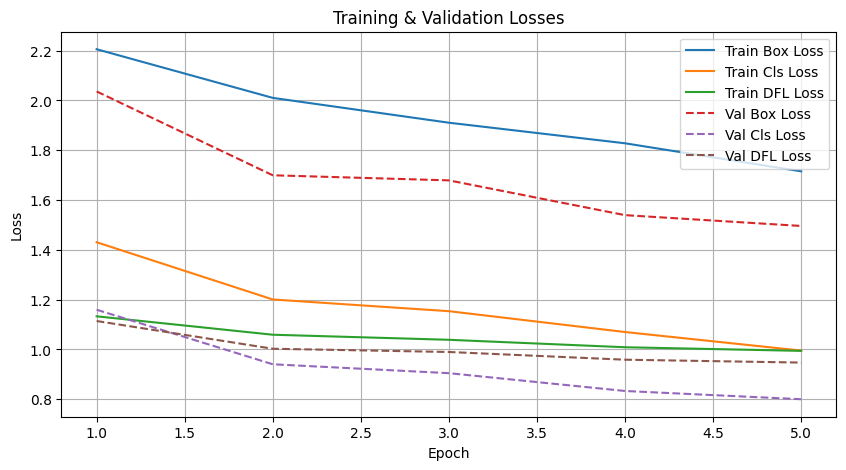

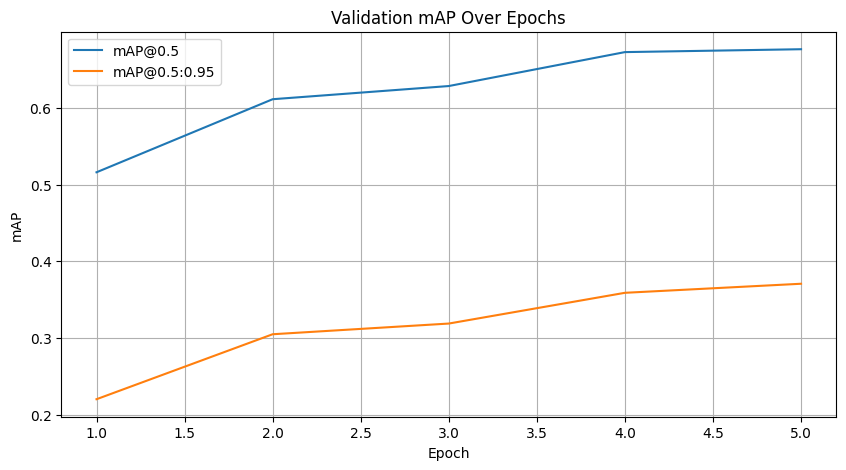

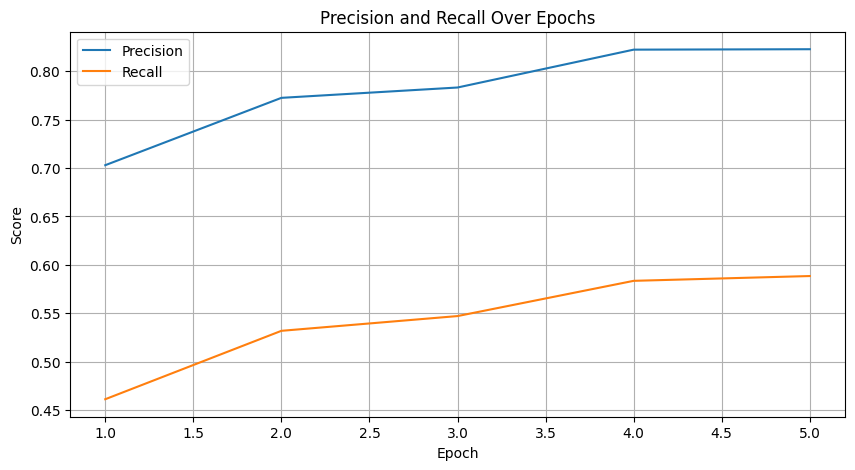

In [21]:
results_csv = os.path.join(OUTPUT_DIR, "exp", "results.csv")
results = pd.read_csv(results_csv)
print("✅ Training results loaded")

# 1️⃣ Losses
plt.figure(figsize=(10,5))
plt.plot(results["epoch"], results["train/box_loss"], label="Train Box Loss")
plt.plot(results["epoch"], results["train/cls_loss"], label="Train Cls Loss")
plt.plot(results["epoch"], results["train/dfl_loss"], label="Train DFL Loss")
plt.plot(results["epoch"], results["val/box_loss"], "--", label="Val Box Loss")
plt.plot(results["epoch"], results["val/cls_loss"], "--", label="Val Cls Loss")
plt.plot(results["epoch"], results["val/dfl_loss"], "--", label="Val DFL Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Losses")
plt.legend()
plt.grid(True)
plt.show()

# 2️⃣ mAP
plt.figure(figsize=(10,5))
plt.plot(results["epoch"], results["metrics/mAP50(B)"], label="mAP@0.5")
plt.plot(results["epoch"], results["metrics/mAP50-95(B)"], label="mAP@0.5:0.95")
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.title("Validation mAP Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# 3️⃣ Precision & Recall
plt.figure(figsize=(10,5))
plt.plot(results["epoch"], results["metrics/precision(B)"], label="Precision")
plt.plot(results["epoch"], results["metrics/recall(B)"], label="Recall")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Precision and Recall Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [18]:
BEST_WEIGHTS = os.path.join(OUTPUT_DIR, "exp", "weights", "best.pt")
TEST_DIR = os.path.join(DATASET_ROOT, "test", "images")
DETECT_OUTPUT = os.path.join(OUTPUT_DIR, "detect")
os.makedirs(DETECT_OUTPUT, exist_ok=True)

# Load best model
best_model = YOLO(BEST_WEIGHTS)
print(f"✅ Loaded model weights from: {BEST_WEIGHTS}")

# Run batch inference
best_model.predict(
    source=TEST_DIR,
    conf=0.25,
    save=True,
    project=DETECT_OUTPUT,
    name="exp",
    exist_ok=True
)
print(f"✅ Inference complete. Predictions in {os.path.join(DETECT_OUTPUT, 'exp')}")

# Visualize random image
sample_img = os.path.join(TEST_DIR, random.choice(os.listdir(TEST_DIR)))
pred = best_model.predict(sample_img, conf=0.25, save=False)
for r in pred:
    plt.imshow(r.plot()); plt.axis("off"); plt.show()


✅ Loaded model weights from: C:\Users\sharm\Downloads\Helmet_Detection\notebook\construction-helmet-detection-2\runs\exp\weights\best.pt

image 1/706 C:\Users\sharm\Downloads\Helmet_Detection\notebook\construction-helmet-detection-2\test\images\005298_jpg.rf.ef704ea8092352ea3e5c2c41c0f701dd.jpg: 128x128 (no detections), 19.3ms
image 2/706 C:\Users\sharm\Downloads\Helmet_Detection\notebook\construction-helmet-detection-2\test\images\005299_jpg.rf.8b93906788e4ec2be34e04b1bc712f39.jpg: 128x128 1 with_helmet, 15.7ms
image 3/706 C:\Users\sharm\Downloads\Helmet_Detection\notebook\construction-helmet-detection-2\test\images\005300_jpg.rf.26ba2d0b2ce4c5a268c196b8ee53e9e1.jpg: 128x128 (no detections), 15.9ms
image 4/706 C:\Users\sharm\Downloads\Helmet_Detection\notebook\construction-helmet-detection-2\test\images\005301_jpg.rf.18cd1a6aa3cbd6cad27655caeefff795.jpg: 128x128 1 with_helmet, 15.8ms
image 5/706 C:\Users\sharm\Downloads\Helmet_Detection\notebook\construction-helmet-detection-2\test\im

<Figure size 640x480 with 1 Axes>